Condition number for J^T J of function example(y,x) based on the initial guess x_0:
Regularization factor 20: 8.599620819091797
Regularization factor 5: 31.398483276367188
Regularization factor 1: 152.99241638183594
Regularization factor 0.1: 1520.9241943359375
Regularization factor 1e-06: 151992416.0

Condition number for J^T J of function example_2(y,x) based on the initial guess x_0:
Regularization factor 20: 8.37929630279541
Regularization factor 5: 27.591243743896484
Regularization factor 1: 87.97476959228516
Regularization factor 0.1: 178.83746337890625
Regularization factor 1e-06: 202.19110107421875



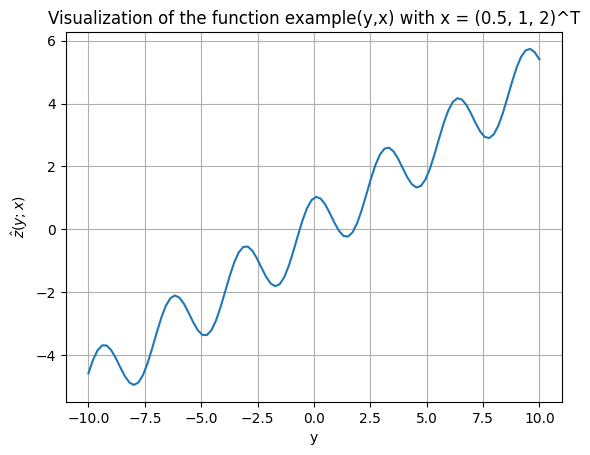


Using the Gauss-Newton method for example(y,x) with 20 as regularization factor and a tolerance of 1e-6, we get:
x = (0.5231, 0.9317, 1.9000) after 45 iterations.

Using the Gauss-Newton method for example_2(y,x) with 20 as regularization factor and a tolerance of 1e-6, we get:
x = (0.4458, -0.1932, 0.4930) after 100 iterations with a Frobenius norm of 3.42e-05.


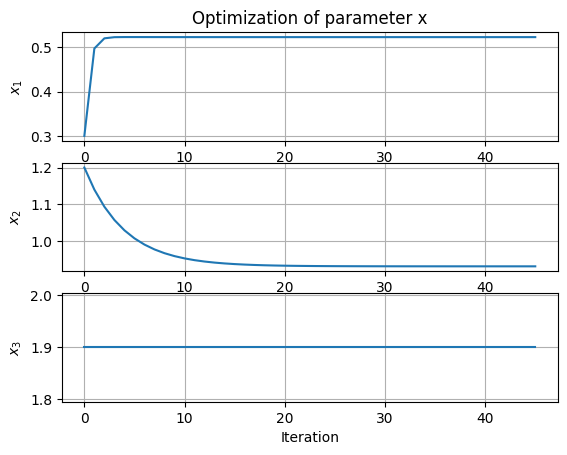

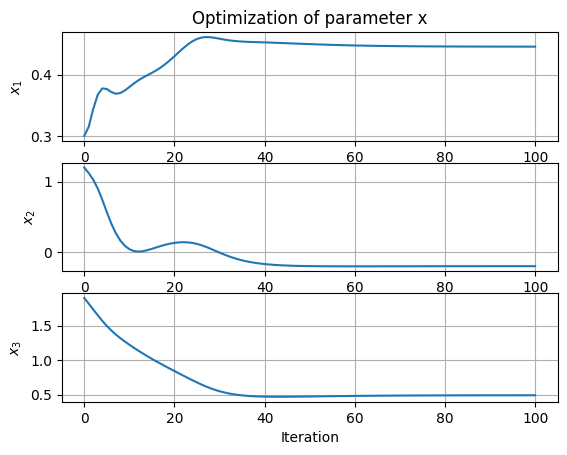


Using the Gauss-Newton method for example(y,x) with 5 as regularization factor and a tolerance of 1e-6, we get:
x = (0.5231, 0.9317, 1.9000) after 17 iterations.

Using the Gauss-Newton method for example_2(y,x) with 5 as regularization factor and a tolerance of 1e-6, we get:
x = (0.4457, -0.1931, 0.4933) after 42 iterations with a Frobenius norm of 7.87e-07.


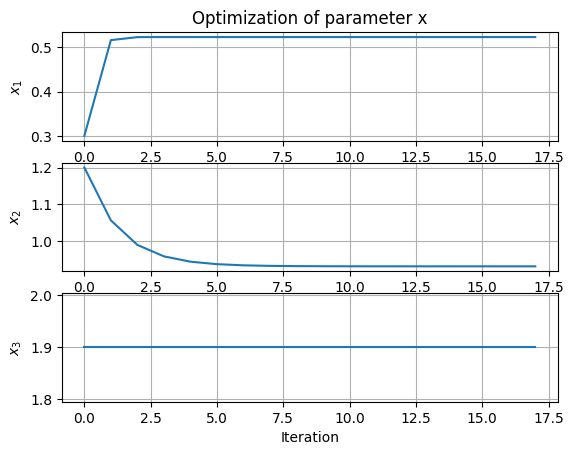

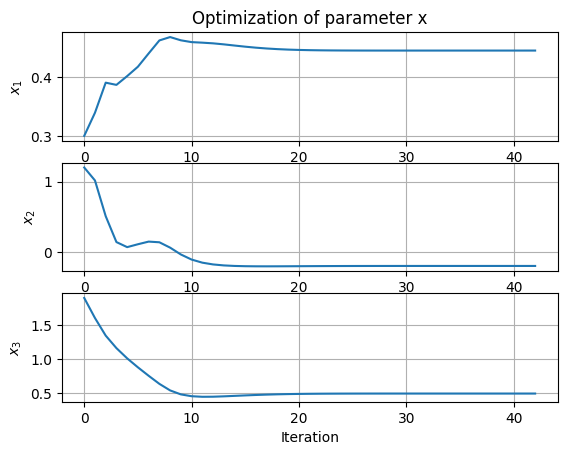


Using the Gauss-Newton method for example(y,x) with 1 as regularization factor and a tolerance of 1e-6, we get:
x = (0.5231, 0.9317, 1.9000) after 8 iterations.

Using the Gauss-Newton method for example_2(y,x) with 1 as regularization factor and a tolerance of 1e-6, we get:
x = (0.4457, -0.1931, 0.4933) after 16 iterations with a Frobenius norm of 7.52e-07.


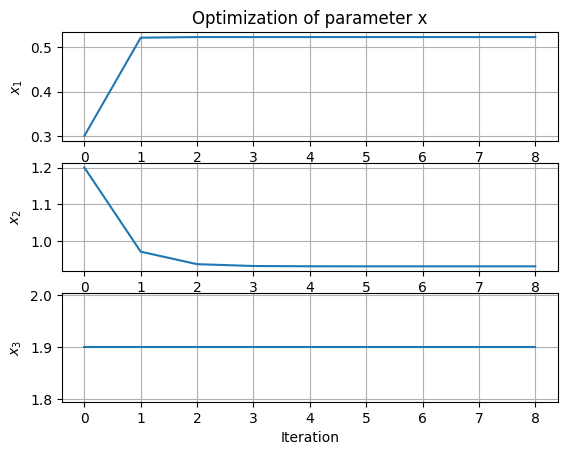

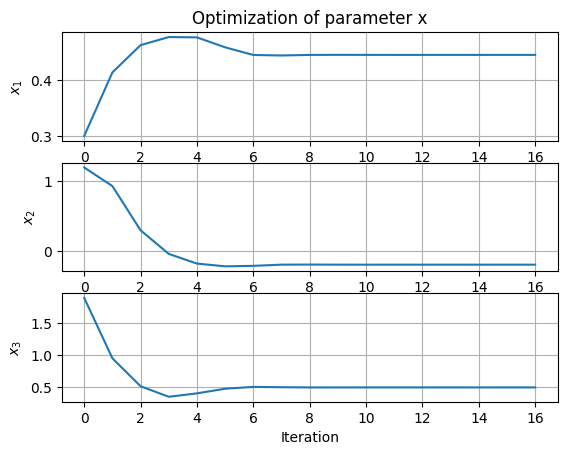


Using the Gauss-Newton method for example(y,x) with 0.1 as regularization factor and a tolerance of 1e-6, we get:
x = (0.5231, 0.9317, 1.9000) after 5 iterations.

Using the Gauss-Newton method for example_2(y,x) with 0.1 as regularization factor and a tolerance of 1e-6, we get:
x = (0.5125, -0.1592, 0.3475) after 100 iterations with a Frobenius norm of 3.96e-01.


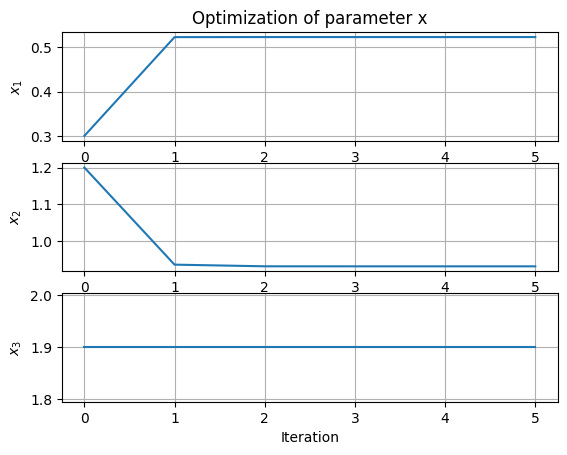

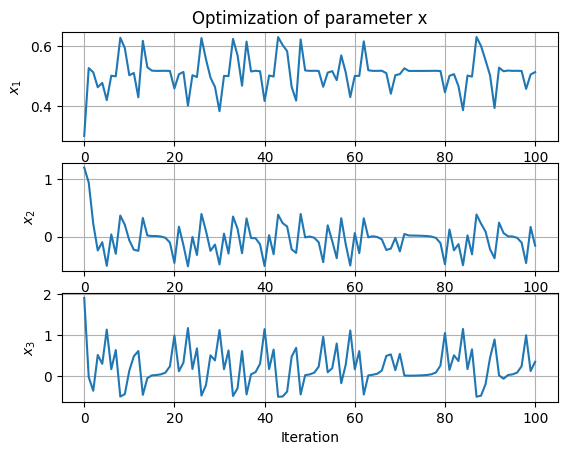


Using the Gauss-Newton method for example(y,x) with 1e-06 as regularization factor and a tolerance of 1e-6, we get:
x = (0.5231, 0.9317, 1.9000) after 2 iterations.

Using the Gauss-Newton method for example_2(y,x) with 1e-06 as regularization factor and a tolerance of 1e-6, we get:
x = (nan, nan, nan) after 100 iterations with a Frobenius norm of nan.


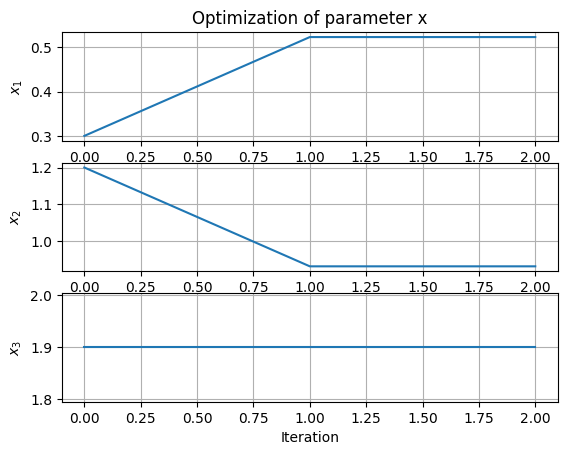

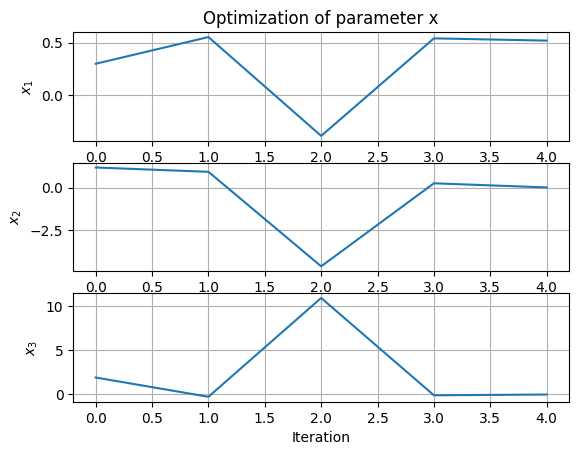

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# given values and an initial guess
y = np.array([0., 0.6283185, 1.2566371, 1.8849556, 2.513274, 3.1415927, 3.7699112, 4.3982297, 5.0265482, 5.6548668, 6.2831853])
z = np.array([0.9299887, 0.53383386, -0.15017393, 0.11093735, 1.5128875, 2.4723399, 2.2487612, 1.3162203, 1.6767914, 3.3423154, 4.0957375])
x_solution = np.array([0.5,1,2])
x_initial = np.array([0.3,1.2,1.9])
reg_values = [20,5,1,1e-1,1e-6]

# function
def example(y,x):
    z_hat = y*x[0] + x[1]*np.cos(x[2]*y)
    return z_hat

def example_2(y,x):
    z_hat = y*x[0] + x[1]*np.cos(x[2]*y) + 0.5*x[2]
    return z_hat

# function for calculating the condintioning number
def calculate_condition_number(H_approx):
    cond_number = np.linalg.cond(H_approx)
    return cond_number

# calculating the Jacobian via tf
def calculate_H_approx(f, x0, y, z, reg_term):
    x = tf.Variable(x0, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)  # w.r.t. x
        res = z - f(y,x) # residual

    J = tape.jacobian(res,x)  # compute Jacobian using automatic differentiation
    J_T = tf.transpose(J)  # transpose Jacobian
    H_approx = J_T @ J  # the Hessian approximation
    H_approx = H_approx + reg_term*tf.eye(tf.shape(J)[1])
    return H_approx.numpy()  # return H_approx as numpy array

# implementation of gauss-newton verfahren
def gauss_newton(f,x0,y,z, reg_term, max_iters=100, tol=1e-6):
    x = tf.Variable(x0, dtype=tf.float32) # convert x0 to a variable form for tf
    history = [x.numpy()] # create list to save each iteration in (numpy form)
    iter_count = 0
    # for loop iterating until 100 (max) or until tol reached (checked after each iteration):
    for _ in range(max_iters):
        with tf.GradientTape() as tape:
            tape.watch(x)  # the w.r.t. x part
            res = z - f(y,x) # residual squared; the term to be 
            obj_fkt = 0.5*tf.reduce_sum(res**2) # the objective function
        
        J = tape.jacobian(res,x) # find Jacobian using automatic differentiation feature
        J_T = tf.transpose(J)
        res_to_column = tf.reshape(res,(-1,1)) # reshape to (n,1) so the multiplication following works
        JT_res = J_T @ res_to_column
        H_approx = J_T @ J # Hessian approximation
        H_approx = H_approx + reg_term*tf.eye(tf.shape(x)[0]) # add small regularization term to ensure that an inverse of H_approx exists
        delta_x = tf.linalg.lstsq(H_approx, -JT_res, fast=True)[:,0] # least squares feature in tf
                
        x.assign_add(delta_x) # update x_k
        history.append(x.numpy())  # save iteration step
        iter_count += 1 # count number of iterations

        # check if we have reached the tolerance, break if it's the case
        if tf.norm(delta_x) < tol:
            break

    return x.numpy(), history, iter_count, tf.norm(delta_x) # return final x and iteration history

print(f"Condition number for J^T J of function example(y,x) based on the initial guess x_0:")
for i in reg_values:
    hessian_approx = calculate_H_approx(example,x_initial,y,z,i)
    cond_number = calculate_condition_number(hessian_approx)
    print(f"Regularization factor {i}: {cond_number}")

print()

print(f"Condition number for J^T J of function example_2(y,x) based on the initial guess x_0:")
for i in reg_values:
    hessian_approx = calculate_H_approx(example_2, x_initial, y, z, i)
    cond_number = calculate_condition_number(hessian_approx)
    print(f"Regularization factor {i}: {cond_number}")

print()

# visualize function example(y,x)
y_values = np.linspace(-10, 10, 100)
z_hat = example(y_values,x_solution)

plt.figure()
plt.plot(y_values,z_hat)
plt.xlabel('y')
plt.ylabel(r'$\hat{z}(y;x)$')
plt.title('Visualization of the function example(y,x) with x = (0.5, 1, 2)^T')
plt.grid(True)
plt.show()

for i in reg_values:
    x_final, hist_list, iter_number, delta_x = gauss_newton(example,x_initial,y,z,i)
    x_final_2, hist_list_2, iter_number_2, delta_x_2 = gauss_newton(example_2,x_initial,y,z,i)

    history_array = np.array(hist_list)  # convert to numpy array
    history_array_2 = np.array(hist_list_2)  # convert to numpy array

    # print the final x value
    print(f"\nUsing the Gauss-Newton method for example(y,x) with {i} as regularization factor and a tolerance of 1e-6, we get:\nx = ({x_final[0]:.4f}, {x_final[1]:.4f}, {x_final[2]:.4f}) after {iter_number} iterations.")
    print(f"\nUsing the Gauss-Newton method for example_2(y,x) with {i} as regularization factor and a tolerance of 1e-6, we get:\nx = ({x_final_2[0]:.4f}, {x_final_2[1]:.4f}, {x_final_2[2]:.4f}) after {iter_number_2} iterations with a Frobenius norm of {delta_x_2:.2e}.")

    # plot the history of the steps for each x-value
    plt.figure
    plt.subplot(3,1,1)
    plt.plot(history_array[:,0], label=r'$x_1$')
    plt.title(f'Optimization of parameter x')
    plt.ylabel(r'$x_1$')
    plt.grid(True)

    plt.subplot(3,1,2)
    plt.plot(history_array[:,1], label=r'$x_2$')
    plt.ylabel(r'$x_2$')
    plt.grid(True)

    plt.subplot(3,1,3)
    plt.plot(history_array[:,2], label=r'$x_3$')
    plt.ylabel(r'$x_3$')
    plt.xlabel('Iteration')
    plt.grid(True)

    plt.show()

    # plot the history of the steps for each x-value
    plt.figure
    plt.subplot(3,1,1)
    plt.plot(history_array_2[:,0], label=r'$x_1$')
    plt.title(f'Optimization of parameter x')
    plt.ylabel(r'$x_1$')
    plt.grid(True)

    plt.subplot(3,1,2)
    plt.plot(history_array_2[:,1], label=r'$x_2$')
    plt.ylabel(r'$x_2$')
    plt.grid(True)

    plt.subplot(3,1,3)
    plt.plot(history_array_2[:,2], label=r'$x_3$')
    plt.ylabel(r'$x_3$')
    plt.xlabel('Iteration')
    plt.grid(True)

    plt.show()
